## Import library

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchmetrics import Accuracy

from sklearn.model_selection import train_test_split, cross_val_score

from kan import *
torch.set_default_dtype(torch.float64)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


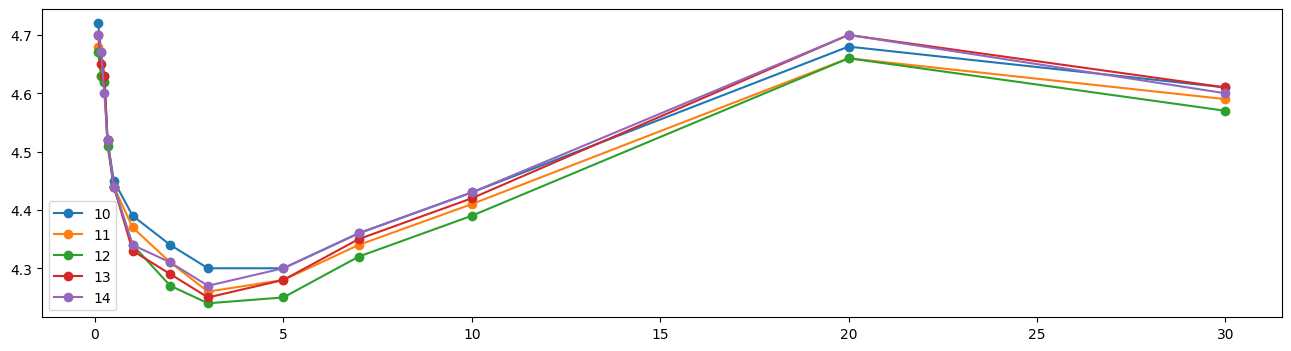

In [12]:
def treasury_data_retrieval():
    df = pd.read_csv('../data/us_treasury_rates.csv')
    df['Date'] = pd.to_datetime(df['Date'])
    df.sort_values(by='Date', ascending=False, inplace=True)

    return df

id_list = range(10, 15)
df = treasury_data_retrieval()
header = [1/12, 2/12, 3/12, 4/12, 6/12, 1, 2, 3, 5, 7, 10, 20, 30]

plt.figure(figsize=(16, 4))
for id in range(10, 15):
    row = df.iloc[id, 1:].values
    plt.plot(header, row, marker='o')
plt.legend(id_list)

## Flatten data

In [32]:
n = len(df)
h = 2

flatten = pd.DataFrame()
for id in range(1, n):
    row = df.iloc[id:(id+h), 1:].stack().reset_index(drop=True).to_frame().T
    flatten = pd.concat([flatten, row], ignore_index=True)
flatten['y'] = df.iloc[:(n-1), 1]
flatten.dropna(inplace=True)
flatten.head()

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,y
0,4.59,4.53,4.46,4.46,4.38,4.23,4.15,4.10,4.07,4.12,...,4.38,4.23,4.13,4.09,4.07,4.13,4.19,4.45,4.35,4.57
1,4.65,4.54,4.47,4.46,4.38,4.23,4.13,4.09,4.07,4.13,...,4.40,4.27,4.17,4.13,4.11,4.17,4.23,4.50,4.40,4.59
2,4.66,4.56,4.49,4.48,4.40,4.27,4.17,4.13,4.11,4.17,...,4.43,4.30,4.17,4.11,4.08,4.13,4.19,4.46,4.36,4.65
3,4.75,4.63,4.51,4.51,4.43,4.30,4.17,4.11,4.08,4.13,...,4.42,4.30,4.13,4.10,4.05,4.10,4.18,4.45,4.36,4.66
4,4.76,4.69,4.58,4.52,4.42,4.30,4.13,4.10,4.05,4.10,...,4.43,4.34,4.19,4.17,4.11,4.17,4.25,4.52,4.44,4.75


## Trial models

In [52]:
df_train, df_test = train_test_split(flatten, test_size=0.2, random_state=42)
X_train, y_train = df_train.drop(columns='y'), df_train['y']
X_test, y_test = df_test.drop(columns='y'), df_test['y']
n = X_train.shape[1]

dataset = dict()
dtype = torch.get_default_dtype()
dataset['train_input'] = torch.from_numpy(X_train.values).type(dtype).to(device)
dataset['train_label'] = torch.from_numpy(y_train.values).type(dtype).to(device)
dataset['test_input'] = torch.from_numpy(X_test.values).type(dtype).to(device)
dataset['test_label'] = torch.from_numpy(y_test.values).type(dtype).to(device)

model = KAN(width=[n,3,1], grid=2, k=2, seed=42, device=device)
# model(dataset['train_input'])
# model.plot()

def train_mse():
    predictions = model(dataset['train_input']).squeeze()  # Model predictions
    mse = F.mse_loss(predictions, dataset['train_label'], reduction='mean')  # Compute MSE
    return mse  # Return scalar MSE value

def test_mse():
    predictions = model(dataset['test_input']).squeeze()  # Model predictions
    mse = F.mse_loss(predictions, dataset['test_label'], reduction='mean')  # Compute MSE
    return mse

results = model.fit(dataset, opt="Adam", steps=50, metrics=(train_mse, test_mse))
results['train_mse'][-1], results['test_mse'][-1]
# dataset['train_input'].cpu().detach().numpy().shape


checkpoint directory created: ./model
saving model version 0.0


description:   0%|                                                           | 0/50 [00:00<?, ?it/s]

| train_loss: 5.74e-01 | test_loss: 6.32e-01 | reg: 2.35e+02 | : 100%|█| 50/50 [00:00<00:00, 58.34it


saving model version 0.1


(0.3212230109043087, 0.38836986050803585)

In [ ]:
model(dataset['test_input'])

In [45]:
dataset['test_label']

tensor([4.7600, 3.8000, 5.4500, 3.8600, 4.6600, 5.5300, 5.5300, 4.2200, 5.3700,
        5.5100, 4.5900, 5.5600, 5.4500, 4.8300, 5.4900, 5.5200, 5.5300, 4.7200,
        5.3700, 5.1700, 5.5900, 4.6500, 5.5200, 5.5400, 5.3400, 4.8100, 5.5000,
        5.5500, 3.9300, 4.6700, 4.6600, 5.4900, 5.5200, 5.5100, 5.5300, 6.0200,
        4.5700, 5.5200, 4.8800, 5.4900, 5.4800, 5.0500, 4.7200, 5.5000, 5.4900,
        3.7500, 5.5200, 5.5000, 5.4900, 5.5400, 5.5300, 4.5300, 3.7600, 5.5100,
        5.5500, 5.5500, 5.4700, 5.1700, 5.5200, 3.3600, 3.6500, 4.6300, 4.6100,
        3.7900, 5.2500, 4.2200, 5.1800, 5.5100, 5.4800, 5.4900, 5.6000, 5.4700,
        5.5000, 5.3000, 4.7400, 4.8000, 5.4800, 5.4800, 4.9200, 5.5300, 3.7800,
        4.5700, 4.6800, 5.5400, 4.7500, 3.8100, 5.5000, 5.5400, 5.5000, 5.4700,
        5.5100, 4.7000, 3.9700, 5.5500, 4.7000, 5.4000, 4.9300, 3.8700, 5.5200,
        4.9300, 5.5000, 4.0400, 5.5100, 5.5300, 3.5500, 5.3100, 3.9100])

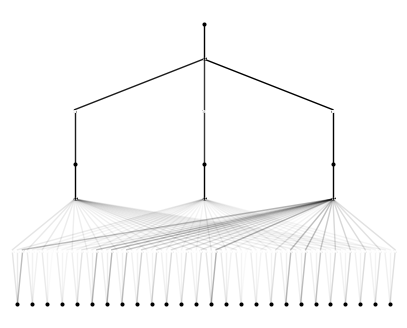

In [49]:
model.plot()